In [118]:
%matplotlib inline
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
from collections import defaultdict
import statistics 

In [4]:
data = pd.read_csv('./google-play-store-apps/googleplaystore.csv')
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [5]:
data= data.replace('-', np.nan)
data= data.replace('Varies with device', np.nan)
data = data.dropna(axis=0, subset=['Type', 'Content Rating', 'Current Ver', 'Android Ver'])
data['Reviews'] = data['Reviews'].astype(str).astype(int)
data['Size'] = data['Size'].astype(str)

#drop rows with nan rating
data['Rating'] = data['Rating'].astype(str)
data = data[data['Rating'] != 'nan']

In [6]:
#standardize rating base 100
data['Rating'] = data['Rating'].astype(float);
data['Rating'] = data['Rating']/5;
data['Rating'] = data['Rating']*100;
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,82.0,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,78.0,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,94.0,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,86.0,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
5,Paper flowers instructions,ART_AND_DESIGN,88.0,167,5.6M,"50,000+",Free,0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up


In [7]:
## Deal with app size in kilobytes: silce the original dataframe to include only apps that are in kilobytes. ##
## Strip "Size" column of letters, and convert string to float. ##
kilo = copy.deepcopy(data)
kilo = kilo[kilo['Size'].apply(lambda x: 'k' in x)]
kilo['Size'] = kilo['Size'].map(lambda x: x.rstrip('k')) 
kilo["Size"]= pd.to_numeric(kilo["Size"])

In [8]:
## Deal with app size in Megabytes: silce the original dataframe to include only apps that are in Megabytes. ##
## Strip "Size" column of letters, and convert string to float. ##
## Note: we are working with size in kilobytes, hence why the "Size" column gets multiplied by 1000 ##
mega = copy.deepcopy(data)
mega = mega[mega['Size'].apply(lambda x: 'M' in x)]
mega['Size'] = mega['Size'].map(lambda x: x.rstrip('M')) 
mega["Size"]= pd.to_numeric(mega["Size"]) * 1000

In [9]:
#combine kilo and mega
frames = [kilo, mega]
data = pd.concat(frames)
data.reset_index(drop=True,inplace=True)
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Restart Navigator,AUTO_AND_VEHICLES,80.0,1403,201.0,"100,000+",Free,0,Everyone,Auto & Vehicles,"August 26, 2014",1.0.1,2.2 and up
1,Plugin:AOT v5.0,BUSINESS,62.0,4034,23.0,"100,000+",Free,0,Everyone,Business,"September 11, 2015",3.0.1.11 (Build 311),2.2 and up
2,Hangouts Dialer - Call Phones,COMMUNICATION,80.0,122498,79.0,"10,000,000+",Free,0,Everyone,Communication,"September 2, 2015",0.1.100944346,4.0.3 and up
3,Caller ID +,COMMUNICATION,80.0,9498,118.0,"1,000,000+",Free,0,Everyone,Communication,"June 7, 2016",5.28.0,2.3 and up
4,GO Notifier,COMMUNICATION,84.0,124346,695.0,"10,000,000+",Free,0,Everyone,Communication,"July 6, 2014",2.8,2.0 and up


In [10]:
def standardize_install(install):
#     print(install)
    install = install.replace('+', '')
    install = install.replace(',', '')
    install = install.strip()
#     print(install)
    if install.isnumeric():
        return int(install)
    return np.nan

data['Installs'] = data['Installs'].astype(str);
data["Installs"] = data["Installs"].apply(standardize_install)
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Restart Navigator,AUTO_AND_VEHICLES,80.0,1403,201.0,100000,Free,0,Everyone,Auto & Vehicles,"August 26, 2014",1.0.1,2.2 and up
1,Plugin:AOT v5.0,BUSINESS,62.0,4034,23.0,100000,Free,0,Everyone,Business,"September 11, 2015",3.0.1.11 (Build 311),2.2 and up
2,Hangouts Dialer - Call Phones,COMMUNICATION,80.0,122498,79.0,10000000,Free,0,Everyone,Communication,"September 2, 2015",0.1.100944346,4.0.3 and up
3,Caller ID +,COMMUNICATION,80.0,9498,118.0,1000000,Free,0,Everyone,Communication,"June 7, 2016",5.28.0,2.3 and up
4,GO Notifier,COMMUNICATION,84.0,124346,695.0,10000000,Free,0,Everyone,Communication,"July 6, 2014",2.8,2.0 and up


In [11]:
def standardize_price(price):
    price = price.replace("$", '')
    if price.isnumeric():
        return float(price)
    return np.nan

data['Price'] = data['Price'].astype(str)
data['Price'] = data['Price'].apply(standardize_price)

In [12]:
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Restart Navigator,AUTO_AND_VEHICLES,80.0,1403,201.0,100000,Free,0.0,Everyone,Auto & Vehicles,"August 26, 2014",1.0.1,2.2 and up
1,Plugin:AOT v5.0,BUSINESS,62.0,4034,23.0,100000,Free,0.0,Everyone,Business,"September 11, 2015",3.0.1.11 (Build 311),2.2 and up
2,Hangouts Dialer - Call Phones,COMMUNICATION,80.0,122498,79.0,10000000,Free,0.0,Everyone,Communication,"September 2, 2015",0.1.100944346,4.0.3 and up
3,Caller ID +,COMMUNICATION,80.0,9498,118.0,1000000,Free,0.0,Everyone,Communication,"June 7, 2016",5.28.0,2.3 and up
4,GO Notifier,COMMUNICATION,84.0,124346,695.0,10000000,Free,0.0,Everyone,Communication,"July 6, 2014",2.8,2.0 and up


In [13]:
df = copy.deepcopy(data)
df['Success'] = df['Installs']

In [141]:
df_success = df.sort_values(by=['Success'], ascending=False)
df_a = df_success[:int(len(df_success)/4)]
df_b = df_success[int(len(df_success)/4): int(len(df_success)/2)]
df_c = df_success[int(len(df_success)/2): int(len(df_success)/4*3)]
df_d = df_success[int(len(df_success)/4*3):]

In [140]:
#get the five dataframe
# df_a = df_success[:int(len(df_success)/10)]
# df_b = df_success[int(len(df_success)/10): int(len(df_success)*0.2)]
# df_c = df_success[int(len(df_success)*0.2): int(len(df_success)*0.3)]
# df_d = df_success[int(len(df_success)*0.3): int(len(df_success)*0.7)]
# df_e = df_success[int(len(df_success)*0.7):]


In [145]:
def visualize_cate(data):
    fig = plt.figure(figsize=(10, 6))
    data_Cat = data['Category'].value_counts()
    data_Cat.plot('bar')
    f1 = plt.gcf()
    
#     print(data['Reviews'].describe())
#     print(data['Rating'].describe())
#     print(data['Size'].describe())

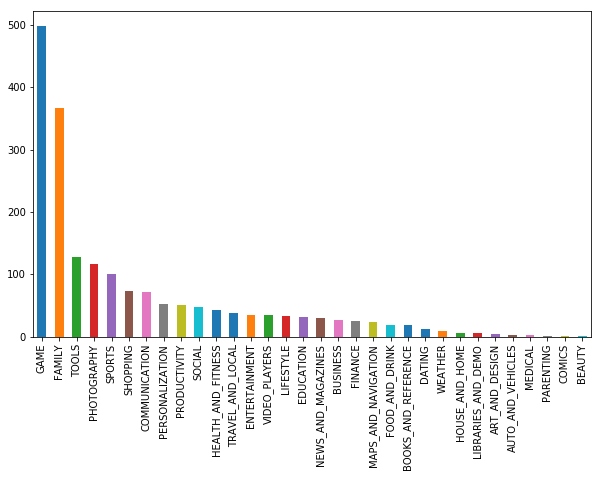

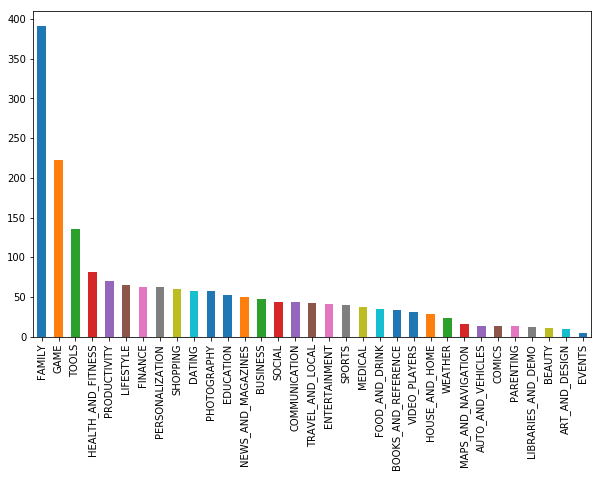

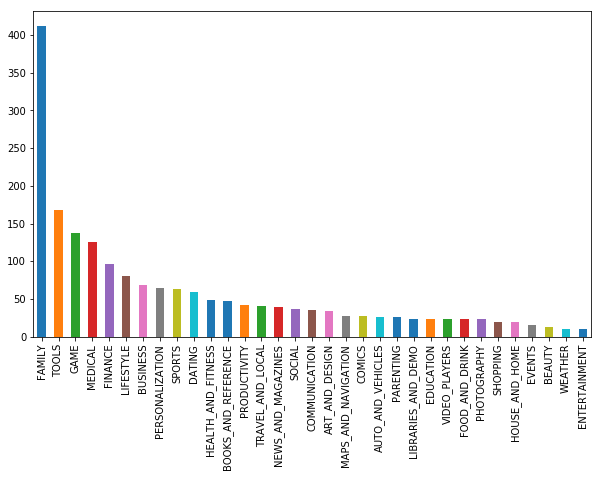

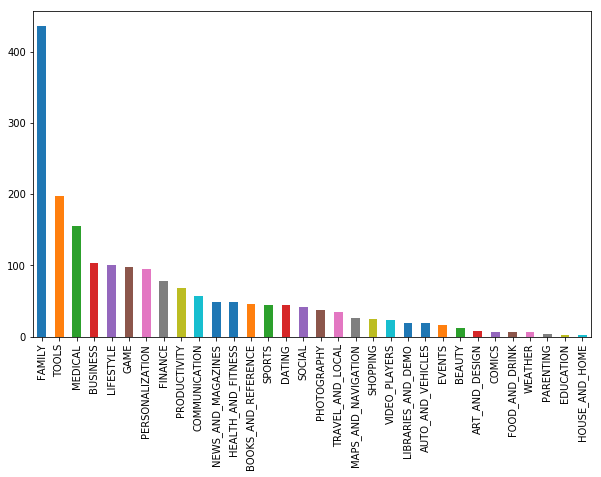

In [147]:
visualize_cate(df_a)
visualize_cate(df_b)
visualize_cate(df_c)
visualize_cate(df_d)

In [109]:
def visualize_rating(data):
    fig = plt.figure(figsize=(10, 6))
    data_plot=data['Rating']
    n, bins, patches = plt.hist(data_plot)
    plt.xlabel(' Rating ')
    plt.ylabel('# Counts')
#     plt.grid(True)

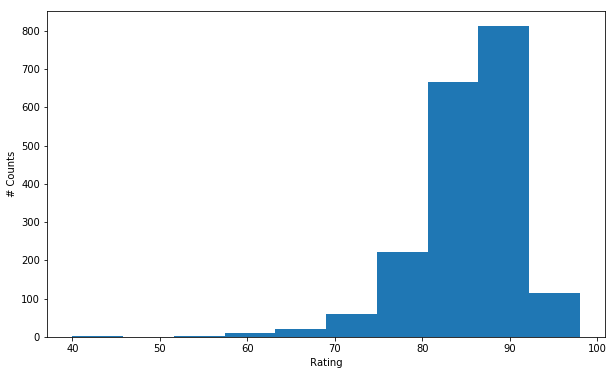

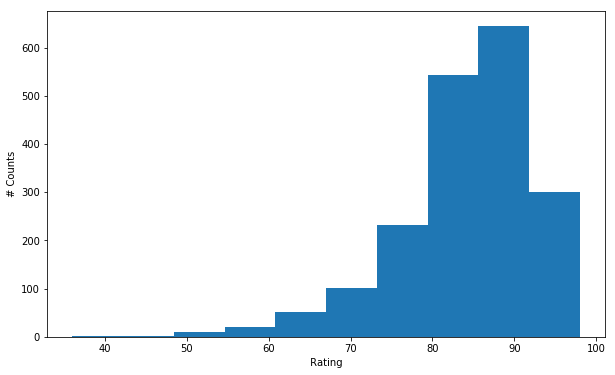

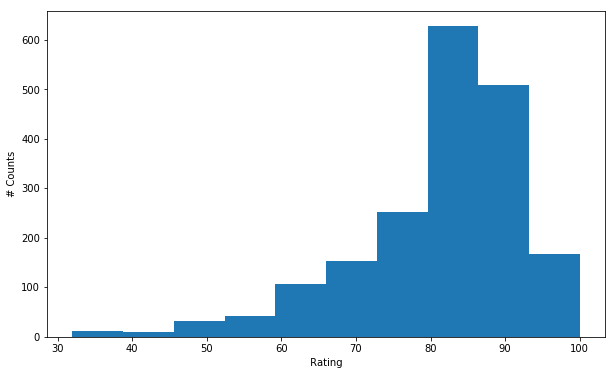

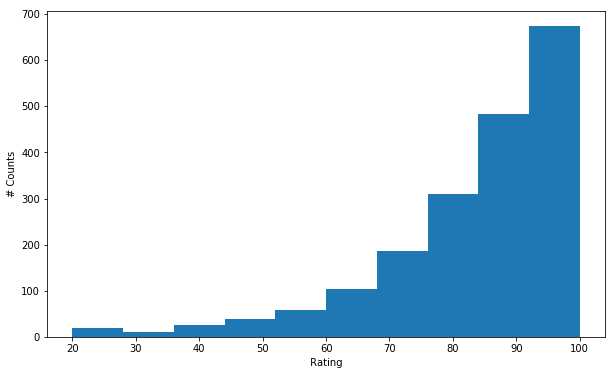

In [110]:
visualize_rating(df_a)
visualize_rating(df_b)
visualize_rating(df_c)
visualize_rating(df_d)

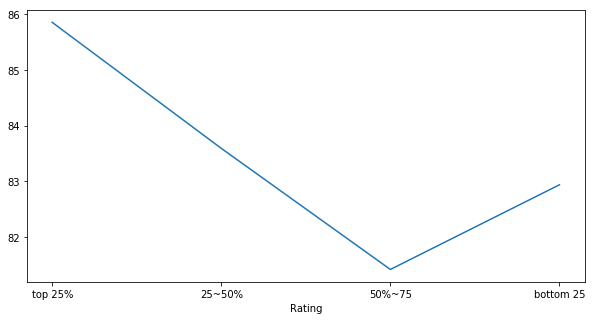

In [134]:
rating_dict = defaultdict(float)
rating_dict["top 25%"] = statistics.mean(df_a['Rating']) 
rating_dict["25~50%"] = statistics.mean(df_b['Rating']) 
rating_dict["50%~75"] = statistics.mean(df_c['Rating']) 
rating_dict["bottom 25"] = statistics.mean(df_d['Rating']) 
# rating_dict["overall"] = statistics.mean(df['Rating'])

plt.figure(figsize=(10, 5))
ax = plt.axes()
plt.plot(rating_dict.keys(), rating_dict.values())
plt.xlabel ('Rating')
plt.show()

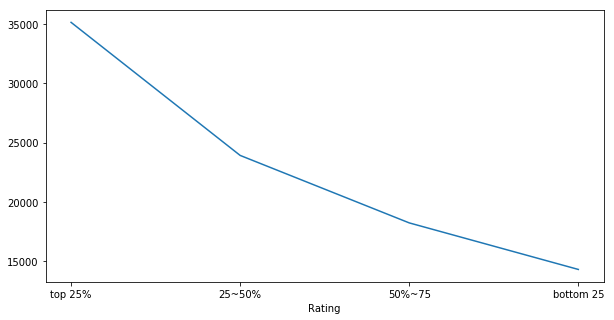

In [138]:
size_dict = defaultdict(float)
size_dict["top 25%"] = statistics.mean(df_a['Size']) 
size_dict["25~50%"] = statistics.mean(df_b['Size']) 
size_dict["50%~75"] = statistics.mean(df_c['Size']) 
size_dict["bottom 25"] = statistics.mean(df_d['Size']) 

plt.figure(figsize=(10, 5))
ax = plt.axes()
plt.plot(size_dict.keys(), size_dict.values())
plt.xlabel ('Rating')
plt.show()

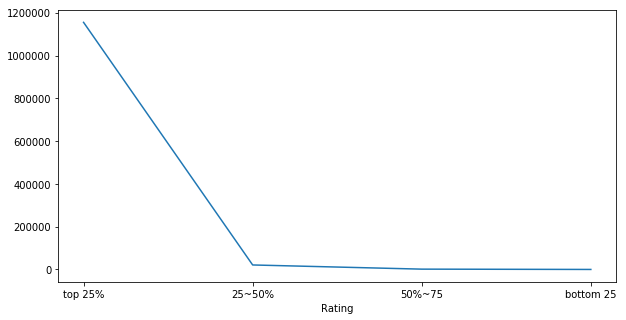

In [139]:
review_dict = defaultdict(float)
review_dict["top 25%"] = statistics.mean(df_a['Reviews']) 
review_dict["25~50%"] = statistics.mean(df_b['Reviews']) 
review_dict["50%~75"] = statistics.mean(df_c['Reviews']) 
review_dict["bottom 25"] = statistics.mean(df_d['Reviews']) 

plt.figure(figsize=(10, 5))
ax = plt.axes()
plt.plot(review_dict.keys(), review_dict.values())
plt.xlabel ('Rating')
plt.show()

In [111]:
outcome, predictors = patsy.dmatrices('Installs ~ Rating+Reviews+Size', df_a)
mod = sm.OLS(outcome, predictors)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               Installs   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     374.4
Date:                Sun, 02 Jun 2019   Prob (F-statistic):          4.14e-191
Time:                        23:36:52   Log-Likelihood:                -37332.
No. Observations:                1909   AIC:                         7.467e+04
Df Residuals:                    1905   BIC:                         7.469e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.752e+07    2.5e+07      2.706      0.0

In [112]:
outcome, predictors = patsy.dmatrices('Installs ~ Rating+Reviews+Size', df_b)
mod = sm.OLS(outcome, predictors)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               Installs   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     119.3
Date:                Sun, 02 Jun 2019   Prob (F-statistic):           7.91e-71
Time:                        23:37:04   Log-Likelihood:                -26938.
No. Observations:                1909   AIC:                         5.388e+04
Df Residuals:                    1905   BIC:                         5.391e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.309e+05   7.91e+04      5.449      0.0